# Introduction

Hello there, This analysis notebook aims to answer some questions I find<br>
interesting about the numbers & stats behind popular movies. Wish you find the<br>
results of the analysis intersting & hopefully get a better understanding of the<br>
mainstream movie industry as a whole.


Here are the questions we are answering in this notebook.
- Which producer have the worst budget to revenue & which have the best
- Highest and lowest budget to revenue per genre
- Wordcloud for the description of movie genres
- How much does the vote avg affect the budget to revenue
- What's the release date distrbution for the movies in this analysis
- What are the most popular runtime for movies per year
- What's the most loved movie series that got better

> **NOTE:** the movies used in the analysis are the top 2000 movies in vote count<br>
> on TMDB, in other words the movies here are the **most voted** on TMDB.

# Setting up

In [66]:
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import requests
import datetime
import duckdb
import PIL
import os

from wordcloud import (
    ImageColorGenerator,
    WordCloud,
    STOPWORDS
)

In [2]:
COLORS = ["#080708", "#3772FF", "#DF2935", "#FDCA40", "#c2c2c2"]
FONT_PATH="../fonts/Inter_24pt-Regular.ttf"
FONT = 25
PAD = 25

if os.path.isfile(FONT_PATH):
    fm.fontManager.addfont(FONT_PATH)
    prop = fm.FontProperties(fname=FONT_PATH)
    plt.rcParams['font.family'] = prop.get_name()

In [3]:
df = pd.read_csv("../data/movies_clean.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            2463 non-null   int64  
 1   id                    2463 non-null   int64  
 2   imdb_id               2463 non-null   object 
 3   release_date          2463 non-null   object 
 4   title                 2463 non-null   object 
 5   collection            991 non-null    object 
 6   overview              2463 non-null   object 
 7   tagline               2387 non-null   object 
 8   language              2463 non-null   object 
 9   runtime               2463 non-null   int64  
 10  revenue               2360 non-null   float64
 11  budget                2368 non-null   float64
 12  vote_avg              2463 non-null   float64
 13  vote_count            2463 non-null   int64  
 14  genres                2463 non-null   object 
 15  production_countries 

# The analysis

### **Q1**. Profitable producers

Firstly we should see which production companies have the best budget to revenue and<br>
which have the worst. which have the worst 

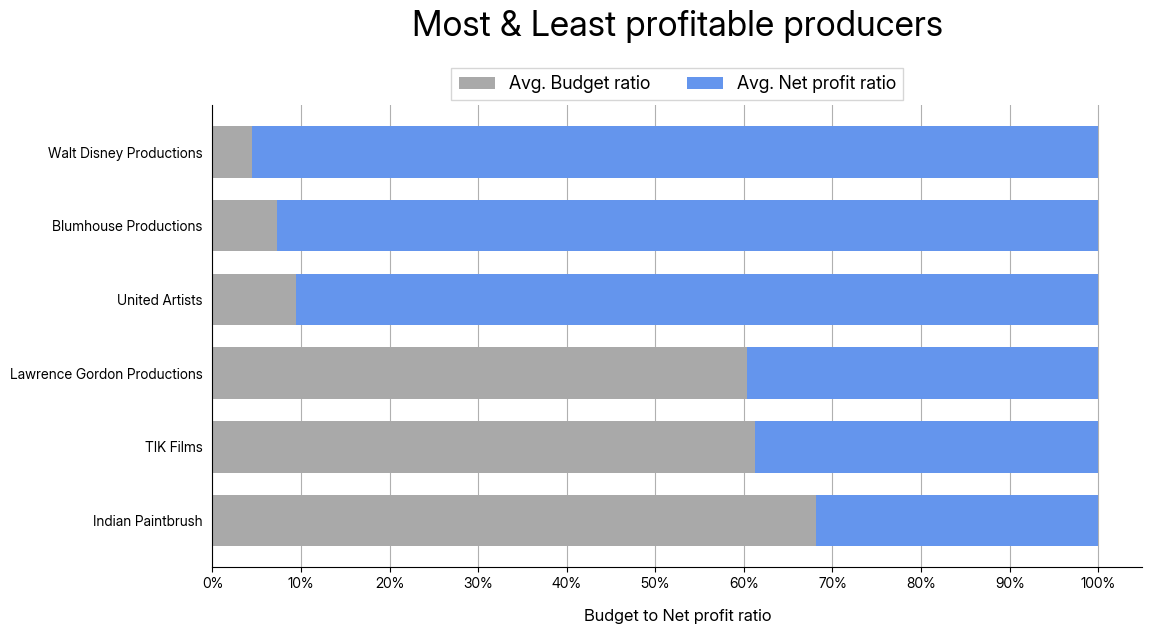

In [95]:
data = duckdb.sql("""
    SELECT producer,
           MEDIAN(budget_to_revenue) AS budget_to_revenue, -- Median is the best for this case
           SUM(occurance) AS occurances,
    FROM (
        SELECT
            UNNEST(SPLIT(production_companies, ', ')) AS producer,
            budget / revenue AS budget_to_revenue,
            1 AS occurance
        FROM df
        WHERE ABS(budget_z_score)  < 3.5 AND -- We don't have to be too strict with outliers
              ABS(revenue_z_score) < 3.5
    )
    GROUP BY producer
    HAVING occurances >= 10 -- Making sure we don't get small producers
    ORDER BY budget_to_revenue DESC -- From most succeful to least succeful
""").df()

data = pd.concat([data.iloc[:3], data.iloc[-3:]])


fig, ax = plt.subplots()

ax.barh(
    data["producer"], data["budget_to_revenue"],
    zorder=2,
    height=0.7,
    color="darkgrey",
    label="Avg. Budget ratio"
)

ax.barh(
    data["producer"], 1-data["budget_to_revenue"],
    left=data["budget_to_revenue"],
    zorder=2,
    height=0.7,
    color="cornflowerblue",
    label="Avg. Net profit ratio" 
)

ax.spines[['right', 'top']].set_visible(False)
ax.grid('off', axis='x', zorder=0)
ax.legend(
    bbox_to_anchor=(0.5, 1.1, 0., 0.), 
    loc="upper center", ncols=2,
    fancybox=False, fontsize=13
) 

ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.yaxis.set_ticks_position('none') 
ax.xaxis.set_major_formatter(
    ticker.FixedFormatter([str(x*10) + "%" for x in range(0, 11)])
)

ax.set_xlabel("Budget to Net profit ratio", fontsize=12, labelpad=13)
ax.set_title("Most & Least profitable producers", fontsize=25, pad=50)

fig.set_size_inches(12, 6)
plt.savefig("../imgs/profitable_producer.jpg")
plt.show()

### **Q2**. Profitable genres

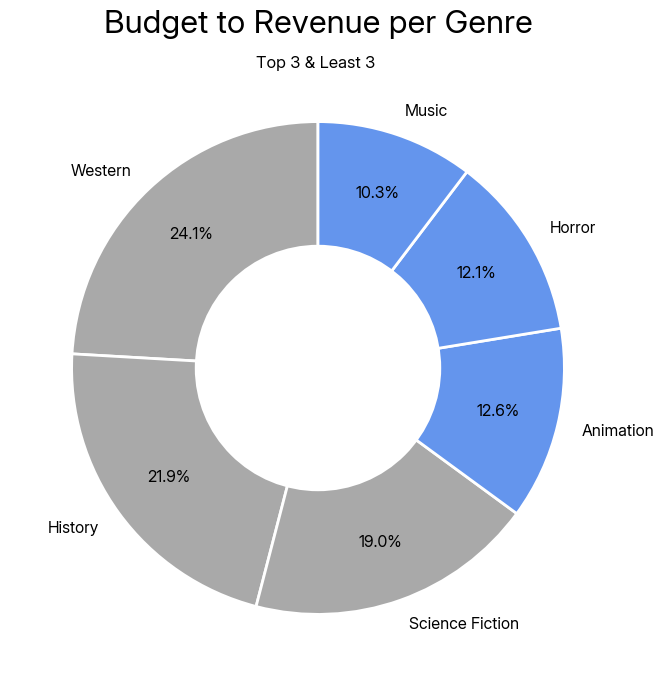

In [94]:
data = duckdb.sql("""
    SELECT genre,
    MEDIAN(budget_to_revenue) AS budget_to_revenue,
    SUM(occurance) AS occurances
    FROM (
        SELECT UNNEST(SPLIT(genres, ', ')) AS genre,
            budget / revenue AS budget_to_revenue,
            1 AS occurance
        FROM df
        WHERE ABS(budget_z_score)  < 3 AND
              ABS(revenue_z_score) < 3
    )
    GROUP BY genre
    HAVING occurances > 20
    ORDER BY budget_to_revenue DESC
""").df()

data = pd.concat([data.iloc[:3], data.iloc[-3:]])

fig, ax = plt.subplots()

colors = ["darkgrey"]*3 + ["cornflowerblue"]*3

ax.pie(
    data["budget_to_revenue"],
    labels=data["genre"],
    autopct='%2.1f%%',
    labeldistance=1.1,
    startangle=90,
    pctdistance=0.75,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2},
    colors=colors,
    textprops={'fontsize':11.5}
)

centre_circle = plt.Circle((0, 0), 0.5, fc='white')
ax.add_artist(centre_circle)

ax.set_title('Budget to Revenue per Genre', fontsize= 23, pad=20)
ax.annotate(xy=(-0.25, 1.22), text='Top 3 & Least 3', fontsize=12)

fig.set_size_inches(10, 8)

plt.show()

### **Q3**. Pobular movies era

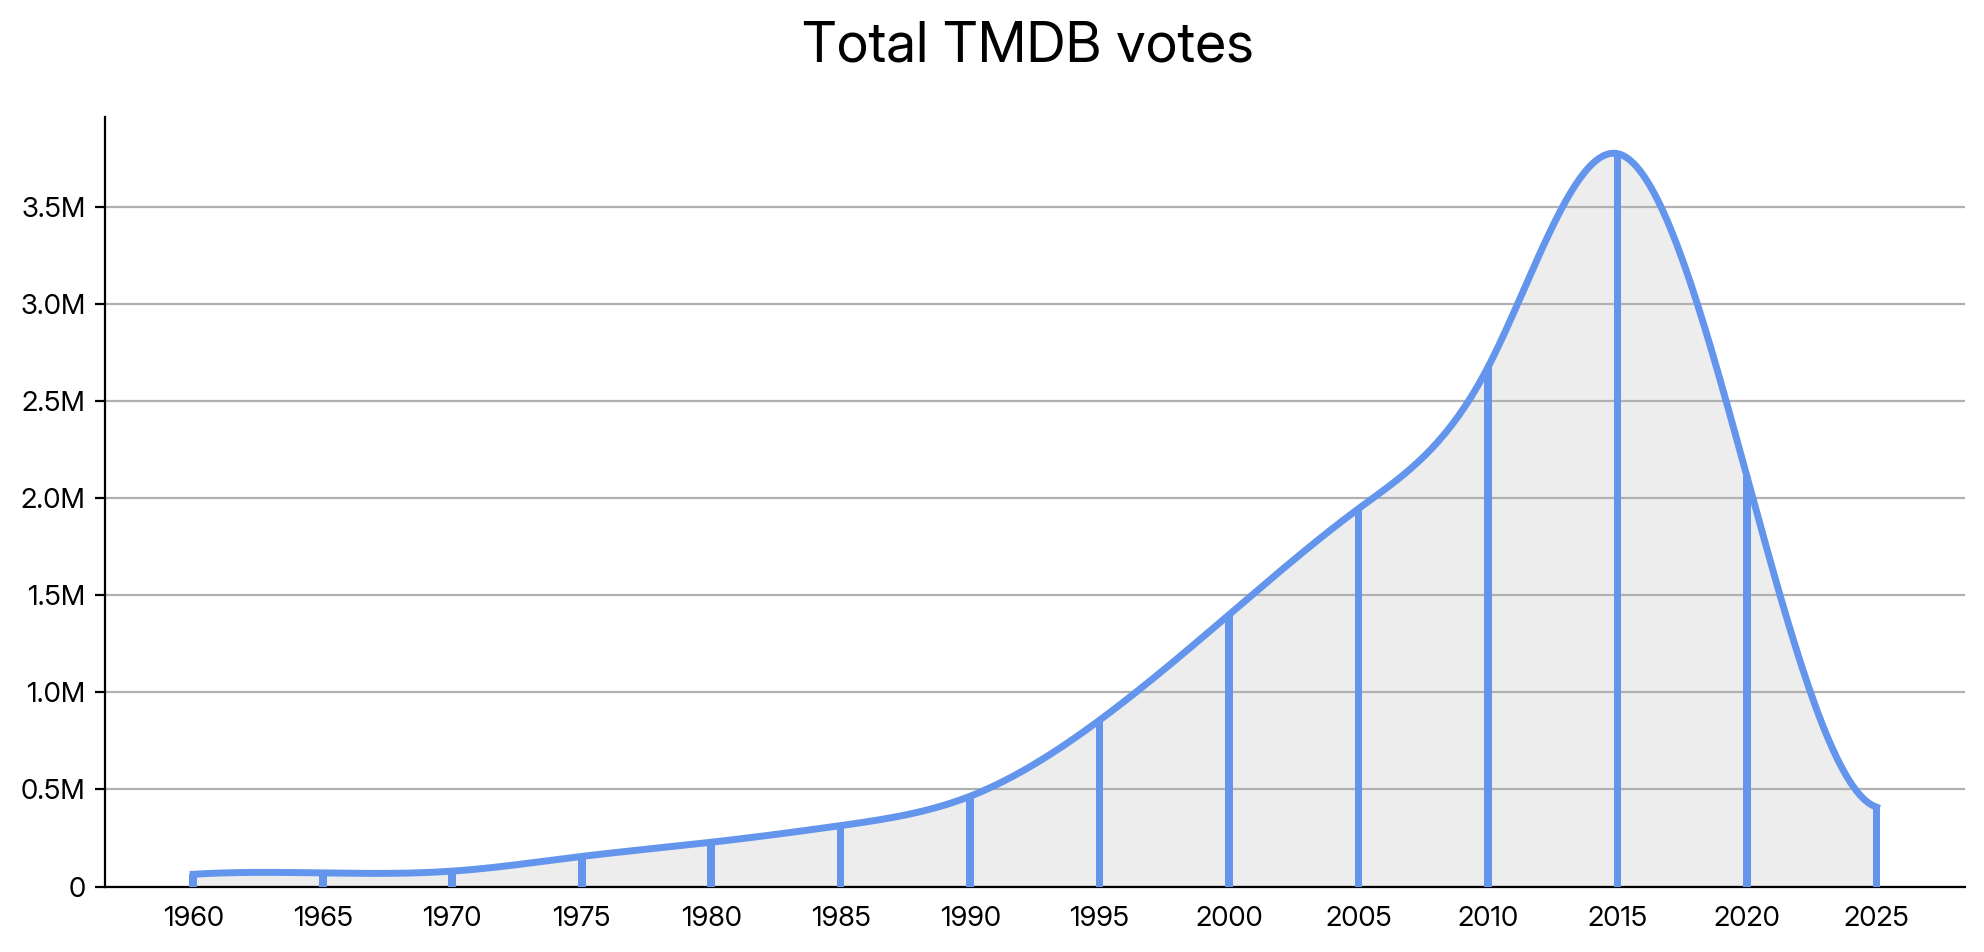

In [101]:
data = duckdb.sql("""
   SELECT 
       SUM(vote_count) AS vote_count,
       COUNT(id) AS occurances,
       ROUND(CAST(SPLIT(release_date, '-')[1] AS INTEGER)/5)*5 AS release_year,
   FROM df
   GROUP BY 
       ROUND(CAST(SPLIT(release_date, '-')[1] AS INTEGER)/5)*5
   HAVING occurances > 10
   ORDER BY release_year ASC
""").df()

fig, ax = plt.subplots()

ax.bar(
    x=data["release_year"],
    height=b(data["release_year"]),
    width=0.3,
    color="cornflowerblue",
    zorder=3
)

spline = interp1d(data["release_year"], data["vote_count"], kind="cubic")
new_x  = np.linspace(
    data["release_year"].min(), data["release_year"].max(), 500
)

ax.plot(
    new_x,
    spline(new_x),
    linewidth=2.5,
    color="cornflowerblue",
    zorder=4
)

ax.fill_between(
    new_x,
    spline(new_x),
    color="darkgrey",
    alpha=0.2
)

ax.set_xticks(data["release_year"], data["release_year"].apply(
    lambda x: f"{x:.0f}"
))
ax.xaxis.set_ticks_position('none') 

ax.spines[['right', 'top']].set_visible(False)
ax.grid('off', axis='y', zorder=0)
ax.yaxis.set_major_formatter(
    lambda x, pos: f"{(x/1_000_000):.1f}M" if x != 0 else 0
)

ax.set_title("Total TMDB votes ", fontsize=20, pad=20)

fig.set_size_inches(12, 5)
plt.gcf().set_dpi(200) 
plt.show()

In [40]:
data

,vote_count,occurances,release_year
0,409524.0,113,2025.0
1,2112240.0,382,2020.0
2,3774192.0,546,2015.0
3,2674187.0,433,2010.0
4,1945841.0,334,2005.0
5,1399828.0,227,2000.0
6,856766.0,139,1995.0
7,465006.0,83,1990.0
8,313875.0,59,1985.0
9,228122.0,41,1980.0


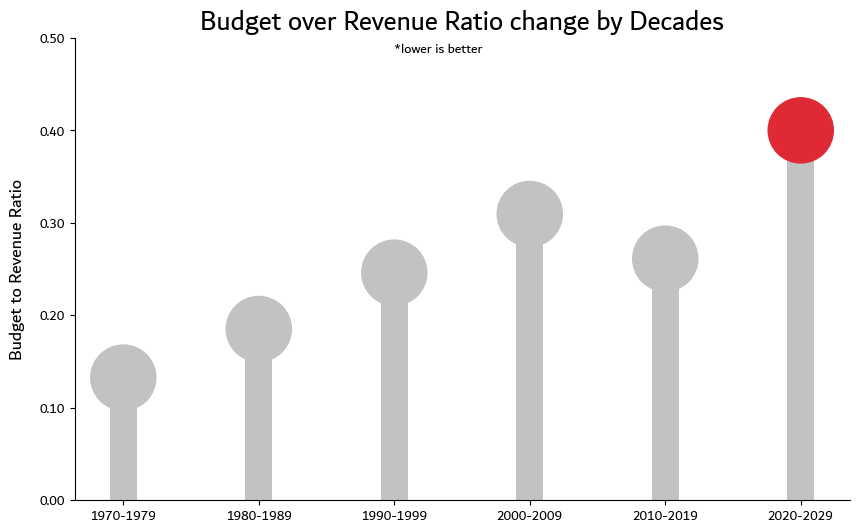

In [303]:
fig, ax = plt.subplots()

x = data_1['release_decade']
y = data_1['budget_to_revenue']

temp_colors = [COLORS[-1]] * 5
temp_colors += [COLORS[2]]

ax.bar     (x, y, width= 0.2, color= COLORS[-1])
ax.scatter (x, y, s= 2200, c= temp_colors)


ax.spines[['right', 'top']].set_visible(False)
ax.set_yticks(np.arange(0, max(y) * 1.5, step= max(y) / 4))

ax.set_ylabel('Budget to Revenue Ratio', labelpad= 10, fontsize= 13)
ax.set_title('Budget over Revenue Ratio change by Decades', fontsize= FONT*.8)
ax.annotate(xy=(2, 0.48), text='*lower is better')


plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda v, _: f'{v:.2f}'))
fig.set_size_inches(10, 6)

plt.savefig('../plots/budget-over-revenue-ratio-change.png')
plt.show()

#### **Question 3:**

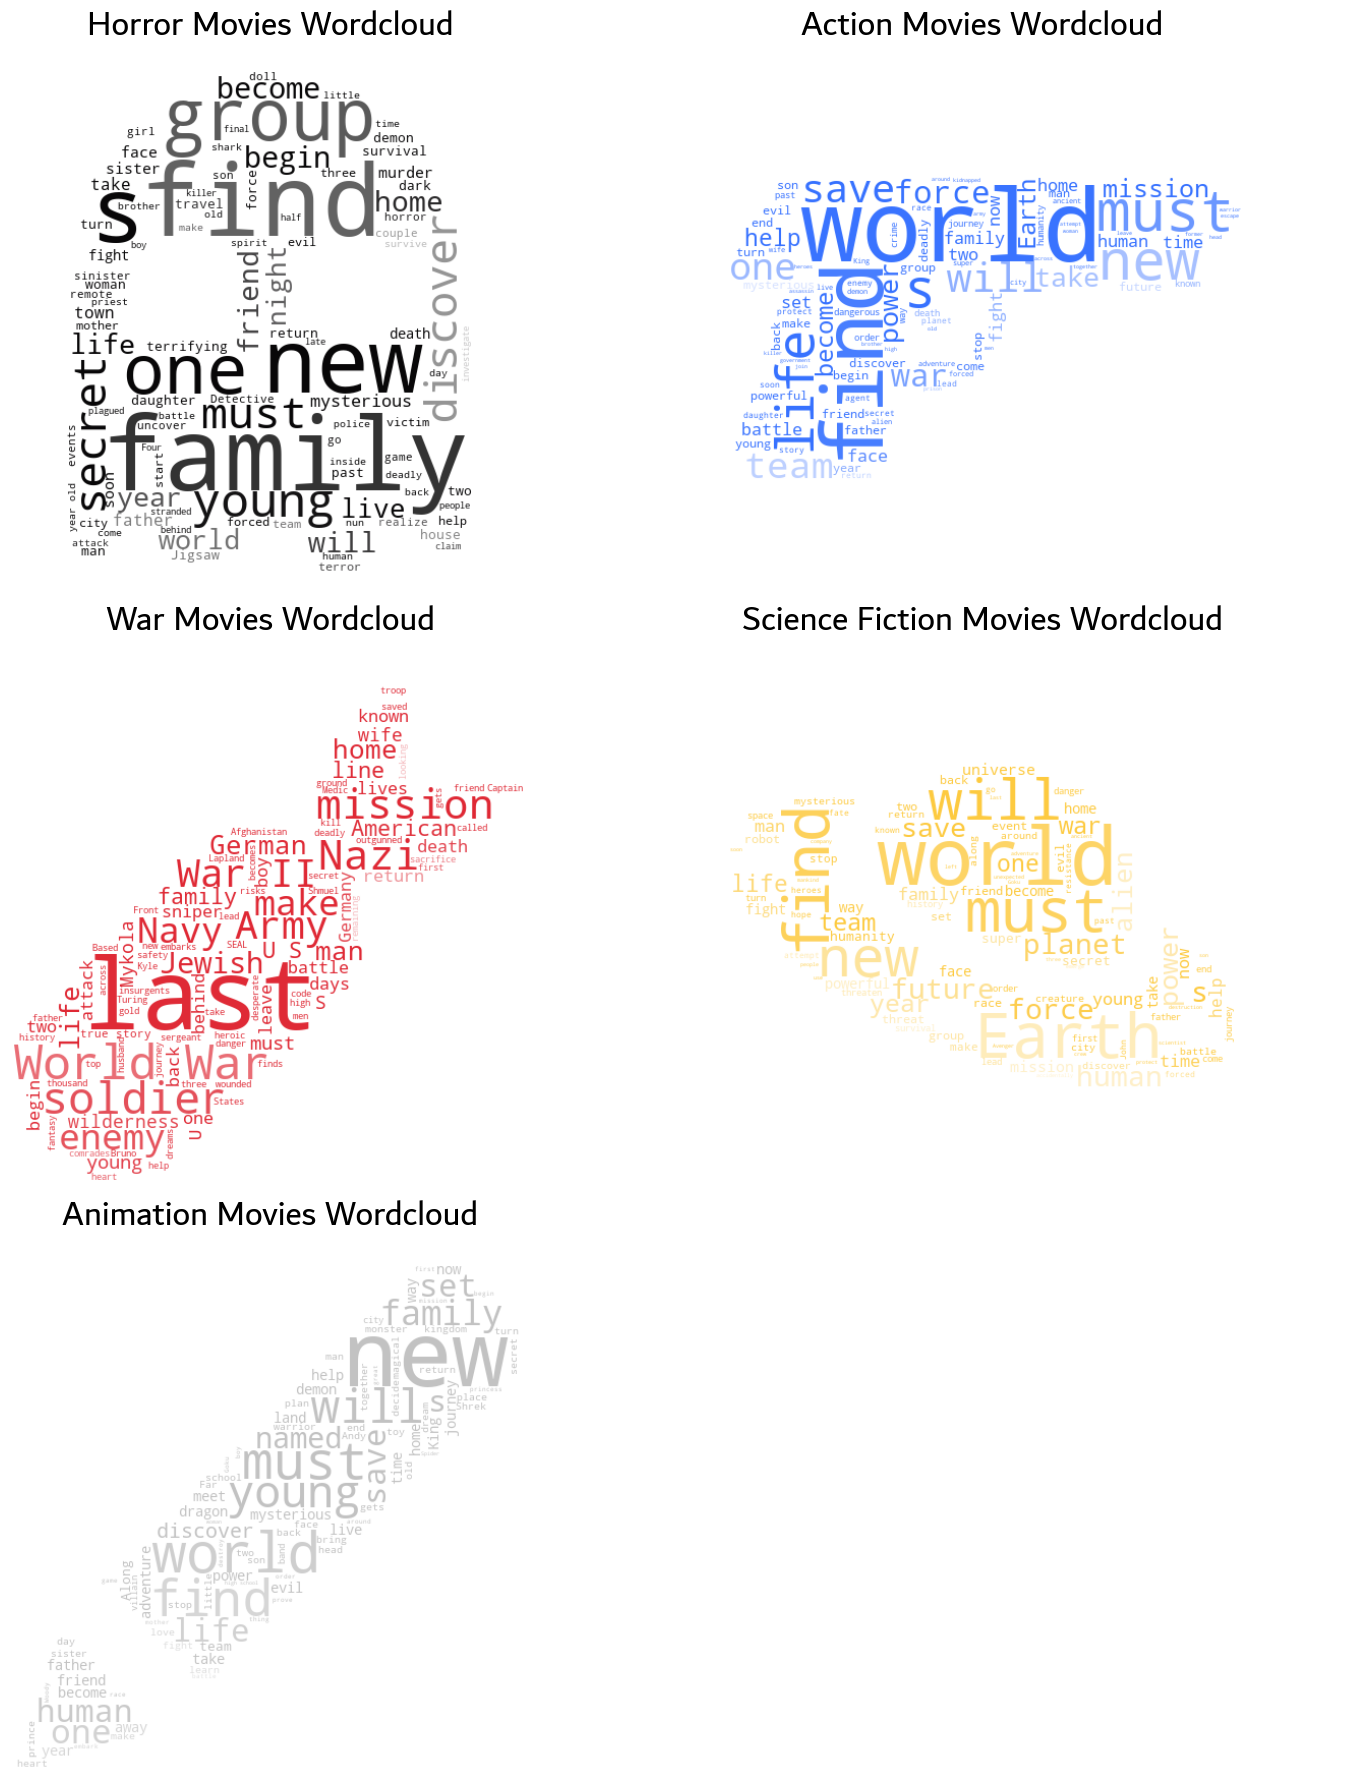

In [315]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2)

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
mask_paths = ['../imgs/assets/ghost.png',     '../imgs/assets/gun.png',
              '../imgs/assets/bomb.png',       '../imgs/assets/ufo.png',
              '../imgs/assets/pen.png']

top_5_genres = (df_without_outliers[['genres', 'popularity']]
                .explode('genres').groupby('genres', as_index=False)
                .mean().sort_values(by='popularity', ascending=False).head(5))['genres']

for ax, color, genre, mask_path in zip_longest(axes, COLORS, top_5_genres, mask_paths, fillvalue=None):

    if genre is not None:
        
        mask = cv2.imread(mask_path)
        
        hex_color = color.lstrip("#")
        desired_color = [int(hex_color[i:i+2], 16) for i in (0, 2, 4)]

        colormap = np.zeros((256, 1, 3), dtype=np.uint8)

        for i in range(256):
            intensity = i / 255.0
            
            if i < 10:
                colormap[i] = desired_color
            elif i == 255:
                colormap[i] = [255, 255, 255]
            else:
                colormap[i] = [
                    int(desired_color[0] * intensity),
                    int(desired_color[1] * intensity),
                    int(desired_color[2] * intensity)]
            
        mask       = cv2.applyColorMap(mask, colormap)        
        text       = ' '.join(df[df['genres'].apply(lambda l: genre in l)]['overview'])
        color_func = ImageColorGenerator(mask)

        wordcloud = WordCloud(
            background_color= 'white',
            mask=             mask,
            stopwords=        STOPWORDS,
            width=            800,
            height=           800,
            max_words=        100,
            max_font_size= 100).generate(text).recolor(color_func=color_func)

        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'{genre} Movies Wordcloud', fontsize= FONT, pad= PAD)

    ax.axis('off')

fig.set_size_inches(15, 18)
plt.tight_layout()

plt.savefig('../plots/movies-genres-wordclouds.png')
plt.show()

#### **Question 4:**

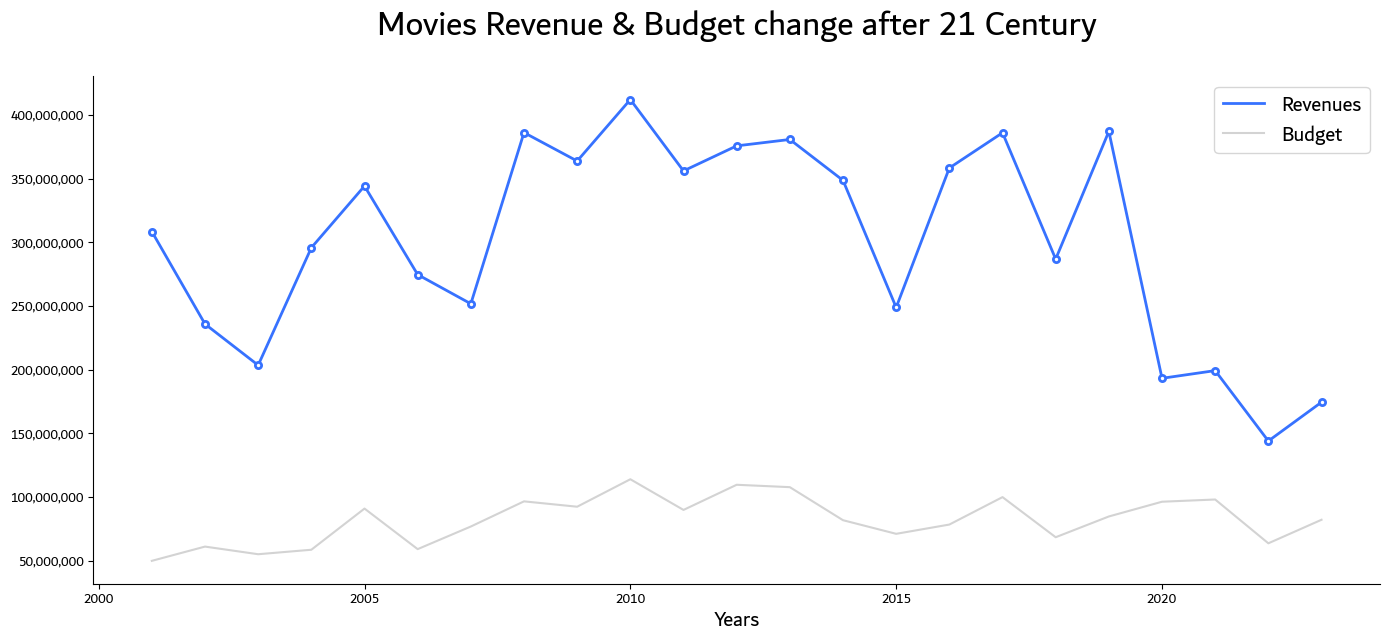

In [306]:
fig, ax = plt.subplots()

df_without_outliers['release_year'] = df_without_outliers['release_date'].dt.year

df_by_year = df_without_outliers[(df_without_outliers['revenue'] > 0) & 
                                 (df_without_outliers['release_year'] > 2000) &
                                 (df_without_outliers['budget'] > 0)
                                ].groupby('release_year')


ax.plot(df_by_year['revenue'].mean().index,
        df_by_year['revenue'].mean(),
        color= COLORS[1], lw=2.0, zorder=10,
        label= 'Revenues')

ax.scatter(df_by_year['revenue'].mean().index,
           df_by_year['revenue'].mean(),
           fc='w', ec= COLORS[1], s=20, lw=2.0, zorder=12)



ax.plot(df_by_year['budget'].mean().index,
        df_by_year['budget'].mean(),
        color='lightgrey', lw=1.5,
        label= 'Budget')


ax.spines[['right', 'top']].set_visible(False)

ax.get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, p: format(int(x), ',')))


ax.set_title('Movies Revenue & Budget change after 21 Century', fontsize=FONT, pad=30)

ax.set_xlabel('Years', fontsize=FONT*3/5)


plt.legend(fontsize= FONT*3/5)
fig.set_size_inches(14, 6.5)
plt.tight_layout()

plt.savefig('../plots/revenue-and-budget-growth.png')
plt.show()

#### **Question 5:**

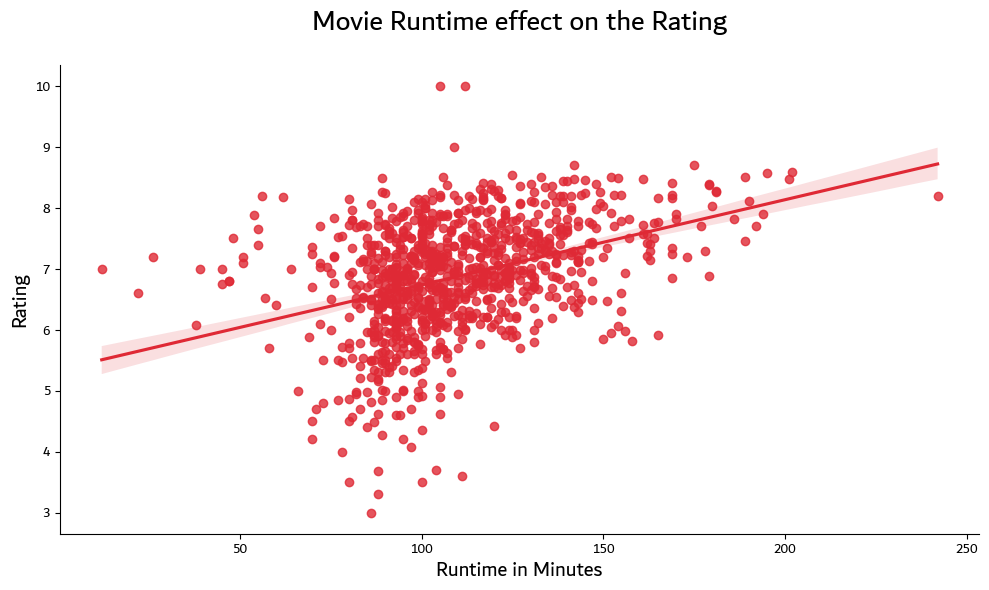

In [307]:
fig, ax = plt.subplots()

sns.regplot(data= df[df['rating'] > 2],
            x='runtime', y='rating', color= COLORS[2], ax= ax)

ax.spines[['right', 'top']].set_visible(False)



ax.set_xlabel('Runtime in Minutes', fontsize=FONT*3/5)
ax.set_ylabel('Rating', fontsize=FONT*3/5)

ax.set_title('Movie Runtime effect on the Rating', fontsize= FONT*5/6, pad= PAD)

fig.set_size_inches(10, 6)
plt.tight_layout()

plt.savefig('../plots/runtime-and-rating-corr.png')
plt.show()

# Summary